In [1]:
import os
import pandas as pd
import numpy as np
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils import get_device, train_clf, eval_clf, test_clf
from BertClassifier import BertClassifier, init_bert_clf


/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-17 14:03:58.731373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Analyze dataset

In [2]:
texts_df = pd.read_csv('subtaskA_train.csv')

In [3]:
texts_df.head()

,Id,comment_text,conspiratorial
0,0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [4]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


In [5]:
texts_df.conspiratorial.value_counts()

1    925
0    917
Name: conspiratorial, dtype: int64

### Test set

In [6]:
texts_df_test = pd.read_csv('subtaskA_test.csv')
texts_df_test.head()

,Id,comment_text
0,0,La CNN ha appena ammesso che Trump non è più a...
1,1,"Notizia del 2017: “Autovelox, la foto viola la..."
2,2,"La foto di due ""sospetti"" in un palazzo non è ..."
3,3,La falsa notizia della bambina con il cartello...
4,4,Ah dimenticavo.. e' gratuita


In [7]:
texts_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            460 non-null    int64 
 1   comment_text  460 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.3+ KB


## Preprocessing

Remove break line characthers

In [8]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))
texts_df_test.comment_text = texts_df_test.comment_text.apply(lambda text: str(text).replace('\n\n', ' ').replace('\n', ' '))


## Train-Validation split

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split of the labeled tr dataset

In [10]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiratorial):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [11]:
print(train_df.info())
print(train_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 1509 to 1768
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1473 non-null   int64 
 1   comment_text    1473 non-null   object
 2   conspiratorial  1473 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 46.0+ KB
None
1    740
0    733
Name: conspiratorial, dtype: int64


In [12]:
print(val_df.info())
print(val_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 361 to 667
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              369 non-null    int64 
 1   comment_text    369 non-null    object
 2   conspiratorial  369 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.5+ KB
None
1    185
0    184
Name: conspiratorial, dtype: int64


## Tokenization

In [13]:
from transformers import BertTokenizer

In [14]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-italian-xxl-cased', do_lower_case=False)

In [15]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiratorial'].to_numpy()

texts_test = texts_df_test['comment_text']

Observe distribution of tokenized texts lengths by trying a simple tokenization on both tr and val sets.

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


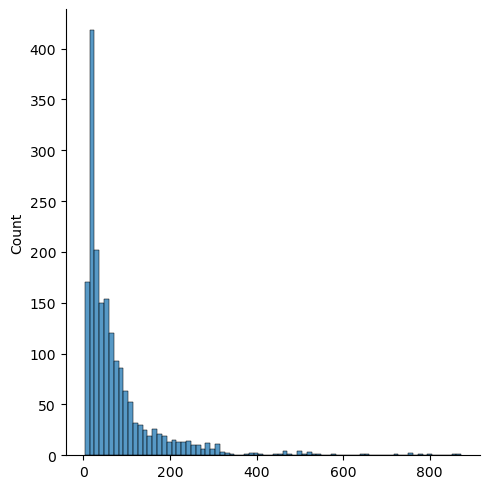

In [16]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

The maximum tokenized length is above the BERT max_lenght limit of 512. Very few texts are above this limit, so we truncate to 512

In [17]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

# Tr set
input_ids_tr = []
attention_masks_tr = []

# `encode_plus` will:
#   1. Tokenize the sentence, 2. Prepend the `[CLS]` token to the start, 3. Append the `[SEP]` token to the end
#   4. Map tokens to their IDs, 5. Pad or truncate the sentence to `max_length`, 6. Create attention masks for [PAD] tokens
for sentence in texts_tr:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_tr.append(encoded_dict['input_ids'])
    attention_masks_tr.append(encoded_dict['attention_mask'])

# Val set
input_ids_val = []
attention_masks_val = []

for sentence in texts_val:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

# Test set
input_ids_test = []
attention_masks_test = []

for sentence in texts_test:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
# Convert the lists into tensors

input_ids_tr = torch.cat(input_ids_tr, dim=0)
input_ids_val = torch.cat(input_ids_val, dim=0)
input_ids_test = torch.cat(input_ids_test, dim=0)

attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

## Generate DataLoaders

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Wrap data into a TensorDataset

In [20]:
tr_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

The DataLoader needs to know our batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [21]:
batch_size = 16

Create the DataLoaders for our training and validation sets. Tr samples are taken in random order, while validation are taken sequentially.

In [22]:
tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)

val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)

test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size = batch_size)

## Training Grid Search

In [23]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [24]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

Set save folder for this run

In [25]:
from datetime import datetime
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './bert_subtaskA/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.year, curr_date.hour, curr_date.minute)
if not os.path.exists(save_folder_pth):
    os.makedirs(save_folder_pth)

2023-04-16 05:01:24.974102


Fixed general hyperparams

In [26]:
max_epochs = 12


# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs

Variable grid searched hyperparams

In [27]:
lr_list = [1e-6, 2e-6, 3e-6]
warmup_perc_list = [0.1, 0.05] # Percentage of warmup steps for scheduler on the total tr steps
clf_head_list = []

head1 = nn.Sequential(
                nn.Linear(768, 128),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(128, 2),
                )
clf_head_list.append((head1, '2_layers_S')) # Each head obeject is composed by a tuple (head, name)

head2 = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(256, 2),
                )
clf_head_list.append((head2, '2_layers_M'))

head3 = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 2),
                )
clf_head_list.append((head3, '3_layers_M'))

Initialize, train/eval and save function for each grid search run

In [28]:
def train_eval_model(lr, warmup_steps, head, model_folder_pth, device):

    torch.cuda.empty_cache()
    #print(torch.cuda.memory_summary())

    # Initialize model
    bert_clf_model, loss_function, optimizer, scheduler = init_bert_clf(tr_steps=tr_steps, lr_rate=lr, scheduler_warmp_steps=warmup_steps, head=head)

    for epoch_i in range(max_epochs):
        print('Epoch: {}'.format(epoch_i))

        # Train
        avg_epoch_loss_tr, acc_score_tr, f1_score_tr, bert_clf_model, optimizer, scheduler = train_clf(bert_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)


        print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

        # Eval
        avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_clf(bert_clf_model, val_dataloader, loss_function, device)
        print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

        # Save
        model_save_pth = os.path.join(model_folder_pth, 'bert_clf_{}.pt'.format(epoch_i))
        torch.save({
                    'epoch': epoch_i,
                    'model_state_dict': bert_clf_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'schdeduler_state_dict': scheduler.state_dict(),
                    'tr_loss': avg_epoch_loss_tr,
                    'val_loss': avg_epoch_loss_val,
                    'tr_acc': acc_score_tr,
                    'val_acc': acc_score_val,
                    'tr_f1': f1_score_tr,
                    'val_f1': f1_score_val,
                    'val_preds': predictions
                    }, model_save_pth)

    torch.cuda.empty_cache()


Grid Search loop

In [29]:
num_trials = len(lr_list) * len(warmup_perc_list) * len(clf_head_list)
print('Executing {} trials in grid search'.format(num_trials))


for lr in lr_list:
    for clf_head_tuple in clf_head_list:
        for warmup_perc in warmup_perc_list:
            
            # Model save path subfolder
            model_folder_str = 'lr{}_warmup{}_head_{}'.format(lr, warmup_perc, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)
            if not os.path.exists(model_folder_pth):
                os.makedirs(model_folder_pth)

            print()
            print('Executing model with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, clf_head_tuple[1]))

            train_eval_model(lr, warmup_steps=warmup_perc*tr_steps, head=clf_head_tuple[0], model_folder_pth=model_folder_pth, device=device)

           

Executing 18 trials in grid search

Executing model with lr=1e-06, warmup perc.=0.1, head=2_layers_S


Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6882566527653766 - Tr acc: 0.539714867617108 - Tr f1: 0.5210210987948478
EVALUATION | Val Loss: 0.6596585934360822 - Val acc: 0.6558265582655827 - Val f1: 0.6554621848739496
Epoch: 1
TRAINING | Tr Loss: 0.6408496633652718 - Tr acc: 0.659877800407332 - Tr f1: 0.6549517405703229
EVALUATION | Val Loss: 0.6055426162978014 - Val acc: 0.6829268292682927 - Val f1: 0.6802118440057776
Epoch: 2
TRAINING | Tr Loss: 0.5988156452614773 - Tr acc: 0.7012898845892735 - Tr f1: 0.7004281974293364
EVALUATION | Val Loss: 0.58031290397048 - Val acc: 0.7046070460704607 - Val f1: 0.7033521407235315
Epoch: 3
TRAINING | Tr Loss: 0.5720456245765891 - Tr acc: 0.7073998642226749 - Tr f1: 0.7068805592171329
EVALUATION | Val Loss: 0.5645577162504196 - Val acc: 0.7289972899728997 - Val f1: 0.7289793759915388
Epoch: 4
TRAINING | Tr Loss: 0.5471987660213183 - Tr acc: 0.7420230821452818 - Tr f1: 0.7416362025036003
EVALUATION | Val Loss: 0.5551088365415732 - Val acc: 0.7317073170731707 - V

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6759276889985607 - Tr acc: 0.5566870332654447 - Tr f1: 0.5415097442448538
EVALUATION | Val Loss: 0.6261142740646998 - Val acc: 0.6910569105691057 - Val f1: 0.6871951219512196
Epoch: 1
TRAINING | Tr Loss: 0.6166865857698585 - Tr acc: 0.6856754921928038 - Tr f1: 0.685368652061046
EVALUATION | Val Loss: 0.5773361772298813 - Val acc: 0.6964769647696477 - Val f1: 0.6937214679551787
Epoch: 2
TRAINING | Tr Loss: 0.5811285181071169 - Tr acc: 0.712152070604209 - Tr f1: 0.711321717522815
EVALUATION | Val Loss: 0.5644400467475256 - Val acc: 0.7208672086720868 - Val f1: 0.7208672086720868
Epoch: 3
TRAINING | Tr Loss: 0.5562570883381751 - Tr acc: 0.7243720298710116 - Tr f1: 0.7236167852851465
EVALUATION | Val Loss: 0.550511414806048 - Val acc: 0.7344173441734417 - Val f1: 0.7339777542372881
Epoch: 4
TRAINING | Tr Loss: 0.5391402283022481 - Tr acc: 0.7433808553971487 - Tr f1: 0.7416949964000208
EVALUATION | Val Loss: 0.5437411914269129 - Val acc: 0.7262872628726287 - V

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6858658861088497 - Tr acc: 0.5369993211133741 - Tr f1: 0.5224625418314572
EVALUATION | Val Loss: 0.6568031087517738 - Val acc: 0.6504065040650406 - Val f1: 0.6427558257345491
Epoch: 1
TRAINING | Tr Loss: 0.6480639179547628 - Tr acc: 0.6442634080108622 - Tr f1: 0.6385621380245601
EVALUATION | Val Loss: 0.6173966514567534 - Val acc: 0.6829268292682927 - Val f1: 0.6829175143400633
Epoch: 2
TRAINING | Tr Loss: 0.6171306974144393 - Tr acc: 0.6809232858112695 - Tr f1: 0.6797008301842098
EVALUATION | Val Loss: 0.5910814131299654 - Val acc: 0.6937669376693767 - Val f1: 0.6930365069899953
Epoch: 3
TRAINING | Tr Loss: 0.5860824836518175 - Tr acc: 0.7019687712152071 - Tr f1: 0.7004756560361627
EVALUATION | Val Loss: 0.5691417207320532 - Val acc: 0.7073170731707317 - Val f1: 0.706832627118644
Epoch: 4
TRAINING | Tr Loss: 0.5607782730492212 - Tr acc: 0.7223353699932111 - Tr f1: 0.722327179541542
EVALUATION | Val Loss: 0.5568319410085678 - Val acc: 0.7046070460704607 -

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6709039973956282 - Tr acc: 0.5987780040733197 - Tr f1: 0.5981549738848255
EVALUATION | Val Loss: 0.6331523160139719 - Val acc: 0.6504065040650406 - Val f1: 0.6331640477493238
Epoch: 1
TRAINING | Tr Loss: 0.6240163266017873 - Tr acc: 0.6822810590631364 - Tr f1: 0.6793429116849191
EVALUATION | Val Loss: 0.5904769313832124 - Val acc: 0.6856368563685636 - Val f1: 0.685357247868274
Epoch: 2
TRAINING | Tr Loss: 0.5790775533645384 - Tr acc: 0.7087576374745418 - Tr f1: 0.7080984225543911
EVALUATION | Val Loss: 0.5636875157554945 - Val acc: 0.7208672086720868 - Val f1: 0.7207359456857976
Epoch: 3
TRAINING | Tr Loss: 0.5537826281080964 - Tr acc: 0.7413441955193483 - Tr f1: 0.7411131966935958
EVALUATION | Val Loss: 0.5456435146431128 - Val acc: 0.7181571815718157 - Val f1: 0.7179064980887975
Epoch: 4
TRAINING | Tr Loss: 0.5272646961353158 - Tr acc: 0.7447386286490156 - Tr f1: 0.7447046242348256
EVALUATION | Val Loss: 0.5385502763092518 - Val acc: 0.7317073170731707 

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6986848846558602 - Tr acc: 0.4989816700610998 - Tr f1: 0.33763465756763344
EVALUATION | Val Loss: 0.6910217603047689 - Val acc: 0.5013550135501355 - Val f1: 0.3339350180505415
Epoch: 1
TRAINING | Tr Loss: 0.6854318059900756 - Tr acc: 0.5173116089613035 - Tr f1: 0.39969735616536506
EVALUATION | Val Loss: 0.6731865132848421 - Val acc: 0.5745257452574526 - Val f1: 0.5242072584817798
Epoch: 2
TRAINING | Tr Loss: 0.6671008127991871 - Tr acc: 0.5763747454175153 - Tr f1: 0.5074550084452942
EVALUATION | Val Loss: 0.6544723684589068 - Val acc: 0.6910569105691057 - Val f1: 0.6891368607744606
Epoch: 3
TRAINING | Tr Loss: 0.6508242750680575 - Tr acc: 0.6517311608961304 - Tr f1: 0.631143327841845
EVALUATION | Val Loss: 0.6334057611723741 - Val acc: 0.7154471544715447 - Val f1: 0.7154471544715447
Epoch: 4
TRAINING | Tr Loss: 0.6318714400773408 - Tr acc: 0.6843177189409368 - Tr f1: 0.6731735015471826
EVALUATION | Val Loss: 0.6189836251238982 - Val acc: 0.726287262872628

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6885407047887002 - Tr acc: 0.5159538357094365 - Tr f1: 0.3848584543459403
EVALUATION | Val Loss: 0.6678600882490476 - Val acc: 0.6422764227642277 - Val f1: 0.6201809107922645
Epoch: 1
TRAINING | Tr Loss: 0.6606567803249564 - Tr acc: 0.6123557365919892 - Tr f1: 0.5747563685451884
EVALUATION | Val Loss: 0.6398032282789549 - Val acc: 0.7073170731707317 - Val f1: 0.7065390279823269
Epoch: 2
TRAINING | Tr Loss: 0.6336940962781188 - Tr acc: 0.6761710794297352 - Tr f1: 0.6683642861761695
EVALUATION | Val Loss: 0.6170504130423069 - Val acc: 0.7100271002710027 - Val f1: 0.7097201085158473
Epoch: 3
TRAINING | Tr Loss: 0.6124431516534539 - Tr acc: 0.7006109979633401 - Tr f1: 0.6971262585877707
EVALUATION | Val Loss: 0.5994872699181238 - Val acc: 0.7154471544715447 - Val f1: 0.7150369580406722
Epoch: 4
TRAINING | Tr Loss: 0.6004368742947938 - Tr acc: 0.714867617107943 - Tr f1: 0.7138228741867919
EVALUATION | Val Loss: 0.5880002540846666 - Val acc: 0.7289972899728997 

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6570564784029479 - Tr acc: 0.6137135098438561 - Tr f1: 0.5983596776860098
EVALUATION | Val Loss: 0.6087267734110355 - Val acc: 0.7018970189701897 - Val f1: 0.7017897025978607
Epoch: 1
TRAINING | Tr Loss: 0.572756766632039 - Tr acc: 0.7107942973523421 - Tr f1: 0.7101583025707539
EVALUATION | Val Loss: 0.56401194135348 - Val acc: 0.7181571815718157 - Val f1: 0.7146341463414634
Epoch: 2
TRAINING | Tr Loss: 0.5185041448441885 - Tr acc: 0.7352342158859471 - Tr f1: 0.7347176454072586
EVALUATION | Val Loss: 0.5236944252004226 - Val acc: 0.7560975609756098 - Val f1: 0.7560527707586531
Epoch: 3
TRAINING | Tr Loss: 0.4866672582844252 - Tr acc: 0.7793618465716226 - Tr f1: 0.7789951567981408
EVALUATION | Val Loss: 0.5000966805964708 - Val acc: 0.7750677506775068 - Val f1: 0.7750677506775068
Epoch: 4
TRAINING | Tr Loss: 0.42650488948309295 - Tr acc: 0.8044806517311609 - Tr f1: 0.804166466628013
EVALUATION | Val Loss: 0.5207365906486908 - Val acc: 0.7696476964769647 - 

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6361947136540567 - Tr acc: 0.6374745417515275 - Tr f1: 0.6344036543738705
EVALUATION | Val Loss: 0.5486812045176824 - Val acc: 0.7181571815718157 - Val f1: 0.7181551116333724
Epoch: 1
TRAINING | Tr Loss: 0.5344184784479039 - Tr acc: 0.7522063815342838 - Tr f1: 0.7516129255802027
EVALUATION | Val Loss: 0.5070363668104013 - Val acc: 0.7588075880758808 - Val f1: 0.7577829405907733
Epoch: 2
TRAINING | Tr Loss: 0.4611875477337068 - Tr acc: 0.7847929395790902 - Tr f1: 0.7840568497081624
EVALUATION | Val Loss: 0.48311655409634113 - Val acc: 0.7588075880758808 - Val f1: 0.7574107861749042
Epoch: 3
TRAINING | Tr Loss: 0.39633452844235206 - Tr acc: 0.8289205702647657 - Tr f1: 0.8288346613545817
EVALUATION | Val Loss: 0.4646772580842177 - Val acc: 0.7940379403794038 - Val f1: 0.7940243257535695
Epoch: 4
TRAINING | Tr Loss: 0.3652139780341938 - Tr acc: 0.846571622539036 - Tr f1: 0.8464639923844945
EVALUATION | Val Loss: 0.4598799118151267 - Val acc: 0.810298102981029

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6543642385031587 - Tr acc: 0.6096401900882552 - Tr f1: 0.6094321012020347
EVALUATION | Val Loss: 0.6074585281312466 - Val acc: 0.6802168021680217 - Val f1: 0.6782293822051433
Epoch: 1
TRAINING | Tr Loss: 0.578184824797415 - Tr acc: 0.7094365241004752 - Tr f1: 0.7090308597759547
EVALUATION | Val Loss: 0.540106538683176 - Val acc: 0.7073170731707317 - Val f1: 0.7069533501970704
Epoch: 2
TRAINING | Tr Loss: 0.5004210326299873 - Tr acc: 0.7678207739307535 - Tr f1: 0.7676896145914419
EVALUATION | Val Loss: 0.5132685955613852 - Val acc: 0.7533875338753387 - Val f1: 0.7532062824762422
Epoch: 3
TRAINING | Tr Loss: 0.45458906568506713 - Tr acc: 0.790224032586558 - Tr f1: 0.789802034106826
EVALUATION | Val Loss: 0.5105212063839039 - Val acc: 0.7669376693766937 - Val f1: 0.7643048128342246
Epoch: 4
TRAINING | Tr Loss: 0.4201265440512729 - Tr acc: 0.8112695179904956 - Tr f1: 0.8110604393981898
EVALUATION | Val Loss: 0.4723296084751685 - Val acc: 0.7777777777777778 - 

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6287380620356529 - Tr acc: 0.6469789545145961 - Tr f1: 0.6469774901830652
EVALUATION | Val Loss: 0.5508446482320627 - Val acc: 0.7127371273712737 - Val f1: 0.7116167276159019
Epoch: 1
TRAINING | Tr Loss: 0.5186211713539657 - Tr acc: 0.7596741344195519 - Tr f1: 0.7596155264613682
EVALUATION | Val Loss: 0.5164423224826654 - Val acc: 0.7560975609756098 - Val f1: 0.7549728485420847
Epoch: 2
TRAINING | Tr Loss: 0.4465332819569495 - Tr acc: 0.7949762389680923 - Tr f1: 0.794710464622598
EVALUATION | Val Loss: 0.4938880621145169 - Val acc: 0.7804878048780488 - Val f1: 0.7790272140528314
Epoch: 3
TRAINING | Tr Loss: 0.40755666407846636 - Tr acc: 0.8357094365241005 - Tr f1: 0.8355941865356091
EVALUATION | Val Loss: 0.45564334839582443 - Val acc: 0.7913279132791328 - Val f1: 0.7913217829417509
Epoch: 4
TRAINING | Tr Loss: 0.3392453589426574 - Tr acc: 0.858112695179905 - Tr f1: 0.8580998767937617
EVALUATION | Val Loss: 0.4530819480617841 - Val acc: 0.7913279132791328

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6745821801565026 - Tr acc: 0.5655125594025797 - Tr f1: 0.49834185465366265
EVALUATION | Val Loss: 0.6471379299958547 - Val acc: 0.6720867208672087 - Val f1: 0.6605593863323627
Epoch: 1
TRAINING | Tr Loss: 0.6229101759131237 - Tr acc: 0.6945010183299389 - Tr f1: 0.6881011176317801
EVALUATION | Val Loss: 0.5871034463246664 - Val acc: 0.7262872628726287 - Val f1: 0.7256344000530047
Epoch: 2
TRAINING | Tr Loss: 0.5652684034198843 - Tr acc: 0.7311608961303462 - Tr f1: 0.7288836088615219
EVALUATION | Val Loss: 0.5577311205367247 - Val acc: 0.7479674796747967 - Val f1: 0.7472249025861624
Epoch: 3
TRAINING | Tr Loss: 0.5231563187735055 - Tr acc: 0.7739307535641547 - Tr f1: 0.773358752419426
EVALUATION | Val Loss: 0.5288282223045826 - Val acc: 0.7723577235772358 - Val f1: 0.7722222222222223
Epoch: 4
TRAINING | Tr Loss: 0.4885408540246307 - Tr acc: 0.7997284453496266 - Tr f1: 0.7994589288508054
EVALUATION | Val Loss: 0.5171197677652041 - Val acc: 0.7777777777777778

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6421417489808093 - Tr acc: 0.6517311608961304 - Tr f1: 0.6415709898137059
EVALUATION | Val Loss: 0.5912985565761725 - Val acc: 0.7181571815718157 - Val f1: 0.7174079528718704
Epoch: 1
TRAINING | Tr Loss: 0.5557115619541496 - Tr acc: 0.7440597420230821 - Tr f1: 0.7432247038734012
EVALUATION | Val Loss: 0.5332582543293635 - Val acc: 0.7669376693766937 - Val f1: 0.7669359576968272
Epoch: 2
TRAINING | Tr Loss: 0.5147494106523453 - Tr acc: 0.7691785471826205 - Tr f1: 0.7688076342136265
EVALUATION | Val Loss: 0.5112658565243086 - Val acc: 0.7750677506775068 - Val f1: 0.7747435001654838
Epoch: 3
TRAINING | Tr Loss: 0.4664134325519685 - Tr acc: 0.8004073319755601 - Tr f1: 0.799915912031048
EVALUATION | Val Loss: 0.494057135656476 - Val acc: 0.7913279132791328 - Val f1: 0.7912297846388973
Epoch: 4
TRAINING | Tr Loss: 0.4239629688121939 - Tr acc: 0.8295994568906992 - Tr f1: 0.8294859762438977
EVALUATION | Val Loss: 0.48475024352471036 - Val acc: 0.7994579945799458 

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6297618381438717 - Tr acc: 0.6456211812627292 - Tr f1: 0.639299827743439
EVALUATION | Val Loss: 0.5690778717398643 - Val acc: 0.7181571815718157 - Val f1: 0.7180557188197955
Epoch: 1
TRAINING | Tr Loss: 0.5126963300249909 - Tr acc: 0.7460964019008826 - Tr f1: 0.7457156308851225
EVALUATION | Val Loss: 0.5011186568687359 - Val acc: 0.7615176151761518 - Val f1: 0.7607427055702918
Epoch: 2
TRAINING | Tr Loss: 0.42265366754865136 - Tr acc: 0.8078750848608283 - Tr f1: 0.8076708536627565
EVALUATION | Val Loss: 0.46244984803100425 - Val acc: 0.7994579945799458 - Val f1: 0.7994565217391304
Epoch: 3
TRAINING | Tr Loss: 0.34556227674086887 - Tr acc: 0.8431771894093686 - Tr f1: 0.8431121125731904
EVALUATION | Val Loss: 0.4452803408106168 - Val acc: 0.7940379403794038 - Val f1: 0.7940001175295293
Epoch: 4
TRAINING | Tr Loss: 0.273962525430546 - Tr acc: 0.8961303462321792 - Tr f1: 0.8960928008778462
EVALUATION | Val Loss: 0.49174432021876174 - Val acc: 0.78319783197831

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6168400904824657 - Tr acc: 0.6558044806517311 - Tr f1: 0.6530180434464445
EVALUATION | Val Loss: 0.5351730398833752 - Val acc: 0.7127371273712737 - Val f1: 0.7116167276159019
Epoch: 1
TRAINING | Tr Loss: 0.4798870051419863 - Tr acc: 0.7637474541751528 - Tr f1: 0.7631001016729828
EVALUATION | Val Loss: 0.523121248309811 - Val acc: 0.7696476964769647 - Val f1: 0.7646065518405945
Epoch: 2
TRAINING | Tr Loss: 0.3833845206686566 - Tr acc: 0.8295994568906992 - Tr f1: 0.8294331137523165
EVALUATION | Val Loss: 0.46911715033153695 - Val acc: 0.7913279132791328 - Val f1: 0.7895411281063665
Epoch: 3
TRAINING | Tr Loss: 0.3032068537287815 - Tr acc: 0.8839103869653768 - Tr f1: 0.8838485031400833
EVALUATION | Val Loss: 0.4704282383124034 - Val acc: 0.7913279132791328 - Val f1: 0.7897467014955193
Epoch: 4
TRAINING | Tr Loss: 0.24313480523164555 - Tr acc: 0.9049558723693143 - Tr f1: 0.904923928077455
EVALUATION | Val Loss: 0.49505938217043877 - Val acc: 0.802168021680216

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.6106942421005618 - Tr acc: 0.6666666666666666 - Tr f1: 0.6666666666666666
EVALUATION | Val Loss: 0.5508098639547825 - Val acc: 0.6991869918699187 - Val f1: 0.6990455337002285
Epoch: 1
TRAINING | Tr Loss: 0.49617057189505587 - Tr acc: 0.7678207739307535 - Tr f1: 0.7676741869431275
EVALUATION | Val Loss: 0.513231223449111 - Val acc: 0.7642276422764228 - Val f1: 0.7611330610058261
Epoch: 2
TRAINING | Tr Loss: 0.38737688085404776 - Tr acc: 0.8282416836388323 - Tr f1: 0.8280882907177946
EVALUATION | Val Loss: 0.47763505143423873 - Val acc: 0.7696476964769647 - Val f1: 0.7671786040366101
Epoch: 3
TRAINING | Tr Loss: 0.31073351827279855 - Tr acc: 0.8744059742023083 - Tr f1: 0.874382816068932
EVALUATION | Val Loss: 0.45722574057678383 - Val acc: 0.7859078590785907 - Val f1: 0.7858512396694214
Epoch: 4
TRAINING | Tr Loss: 0.24494066790387195 - Tr acc: 0.9042769857433809 - Tr f1: 0.9042259587295425
EVALUATION | Val Loss: 0.5061562992632389 - Val acc: 0.791327913279

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.5878605387544119 - Tr acc: 0.703326544467074 - Tr f1: 0.7030369350986545
EVALUATION | Val Loss: 0.5110225162158409 - Val acc: 0.7452574525745257 - Val f1: 0.7410564978499761
Epoch: 1
TRAINING | Tr Loss: 0.4404422595936765 - Tr acc: 0.7997284453496266 - Tr f1: 0.7995654911403091
EVALUATION | Val Loss: 0.44554414600133896 - Val acc: 0.7750677506775068 - Val f1: 0.7735710958812962
Epoch: 2
TRAINING | Tr Loss: 0.3053234336817617 - Tr acc: 0.8703326544467074 - Tr f1: 0.870317353569277
EVALUATION | Val Loss: 0.49331515344480675 - Val acc: 0.7777777777777778 - Val f1: 0.7741131151457239
Epoch: 3
TRAINING | Tr Loss: 0.2196345650140316 - Tr acc: 0.9185336048879837 - Tr f1: 0.9185335673411599
EVALUATION | Val Loss: 0.4623038774977128 - Val acc: 0.7994579945799458 - Val f1: 0.7994447382337388
Epoch: 4
TRAINING | Tr Loss: 0.1789095774292946 - Tr acc: 0.9341479972844535 - Tr f1: 0.9341449621110337
EVALUATION | Val Loss: 0.5079493119070927 - Val acc: 0.8075880758807588

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.642169633219319 - Tr acc: 0.6530889341479973 - Tr f1: 0.6473443169812382
EVALUATION | Val Loss: 0.5727281818787257 - Val acc: 0.7208672086720868 - Val f1: 0.7192506851237654
Epoch: 1
TRAINING | Tr Loss: 0.5393986322226063 - Tr acc: 0.7488119484046164 - Tr f1: 0.7484863308290107
EVALUATION | Val Loss: 0.5233418221275011 - Val acc: 0.7669376693766937 - Val f1: 0.7650586353944564
Epoch: 2
TRAINING | Tr Loss: 0.45024532344072093 - Tr acc: 0.7970128988458928 - Tr f1: 0.7968147450675005
EVALUATION | Val Loss: 0.4800071759770314 - Val acc: 0.7831978319783198 - Val f1: 0.7821980875929642
Epoch: 3
TRAINING | Tr Loss: 0.38038537979766884 - Tr acc: 0.8458927359131025 - Tr f1: 0.8458643202575542
EVALUATION | Val Loss: 0.4945766379435857 - Val acc: 0.7696476964769647 - Val f1: 0.7649804806042395
Epoch: 4
TRAINING | Tr Loss: 0.3107058461154661 - Tr acc: 0.8906992532247114 - Tr f1: 0.8906919987002122
EVALUATION | Val Loss: 0.4692449929813544 - Val acc: 0.794037940379403

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.5878635359707699 - Tr acc: 0.6978954514596063 - Tr f1: 0.6970890772581475
EVALUATION | Val Loss: 0.510137482235829 - Val acc: 0.7506775067750677 - Val f1: 0.7506317212199565
Epoch: 1
TRAINING | Tr Loss: 0.46662758803495796 - Tr acc: 0.7868295994568907 - Tr f1: 0.7864633925636471
EVALUATION | Val Loss: 0.4945083409547806 - Val acc: 0.7696476964769647 - Val f1: 0.7642172523961662
Epoch: 2
TRAINING | Tr Loss: 0.37806439415741994 - Tr acc: 0.8411405295315683 - Tr f1: 0.8410402331716136
EVALUATION | Val Loss: 0.4504054132848978 - Val acc: 0.7967479674796748 - Val f1: 0.7966942148760331
Epoch: 3
TRAINING | Tr Loss: 0.290169751612089 - Tr acc: 0.8981670061099797 - Tr f1: 0.8980955701666998
EVALUATION | Val Loss: 0.48970691797633964 - Val acc: 0.7804878048780488 - Val f1: 0.777321661389458
Epoch: 4
TRAINING | Tr Loss: 0.23915805579513633 - Tr acc: 0.9205702647657841 - Tr f1: 0.9205666037834117
EVALUATION | Val Loss: 0.49778674232463044 - Val acc: 0.80487804878048

## Analyze grid search results

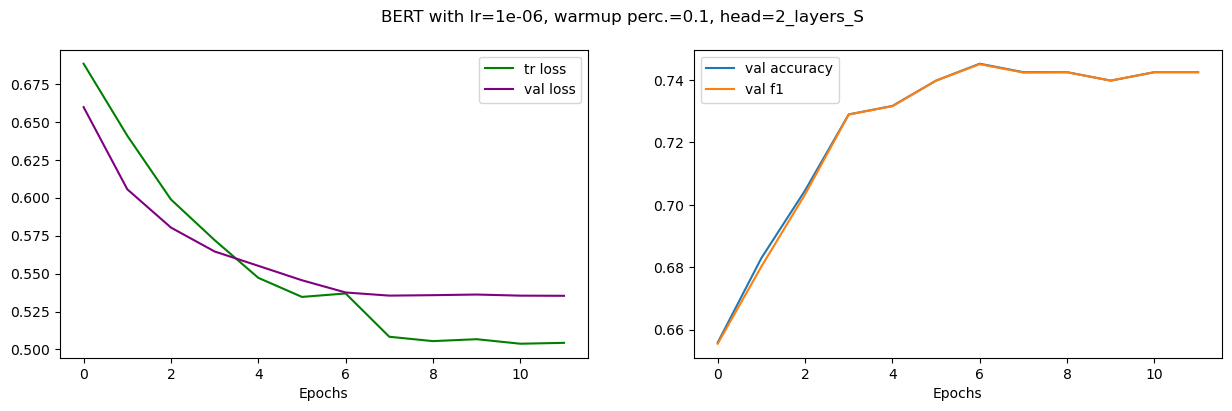

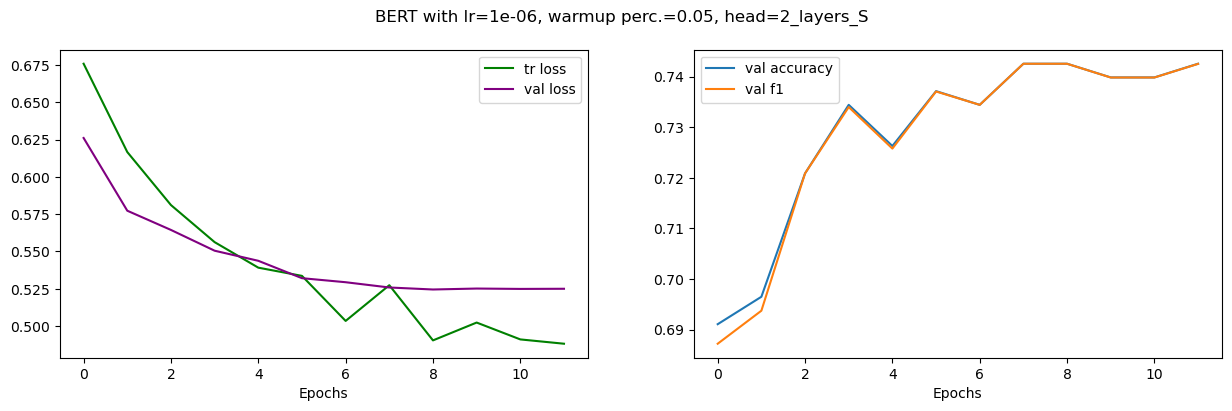

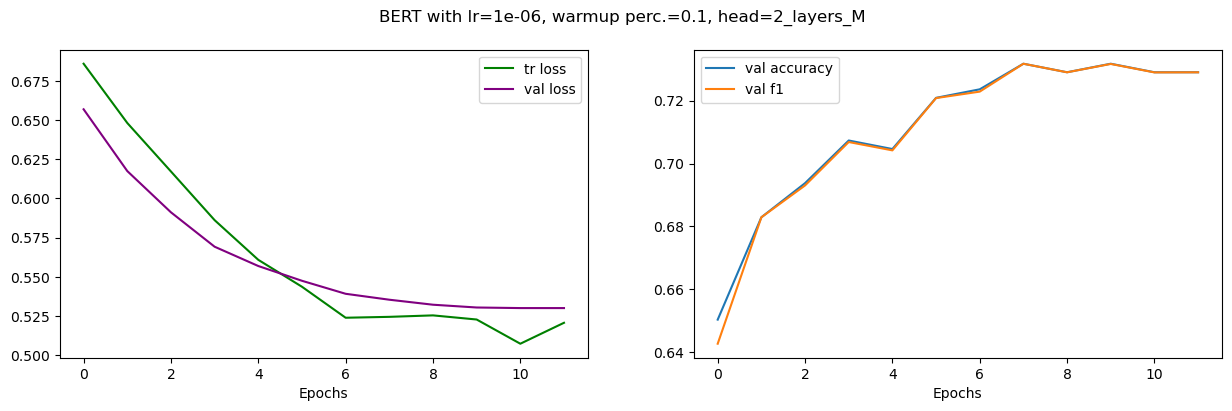

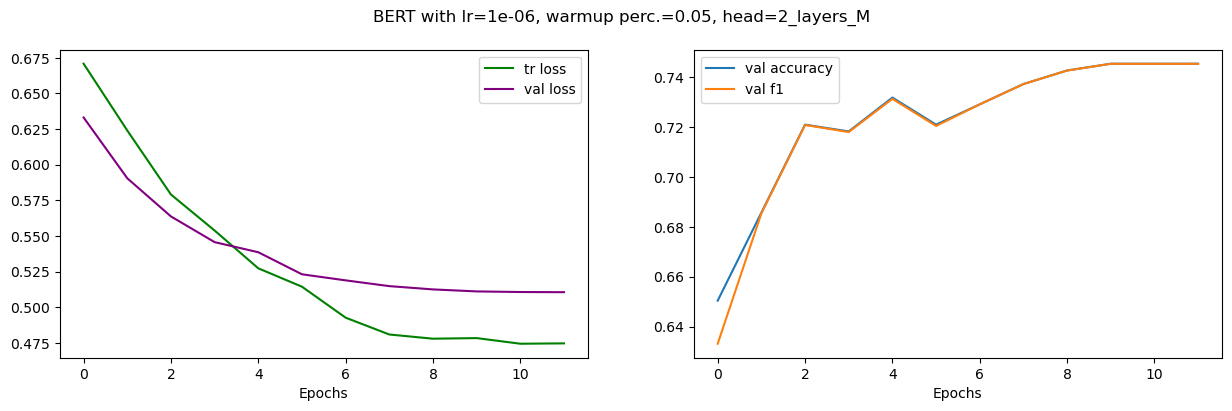

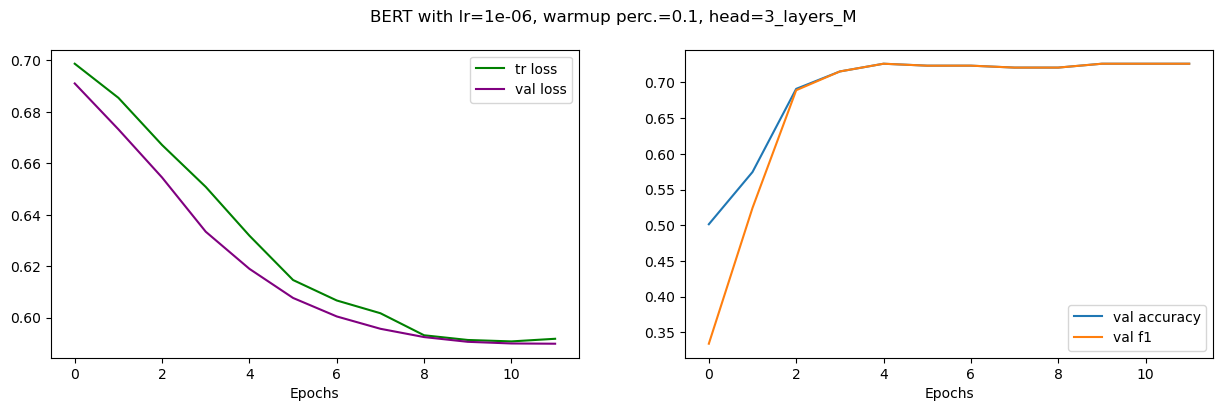

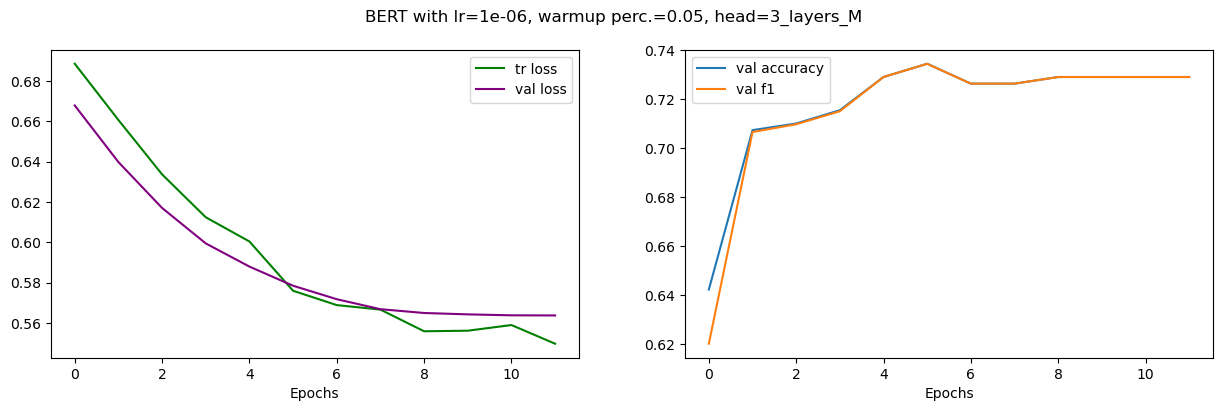

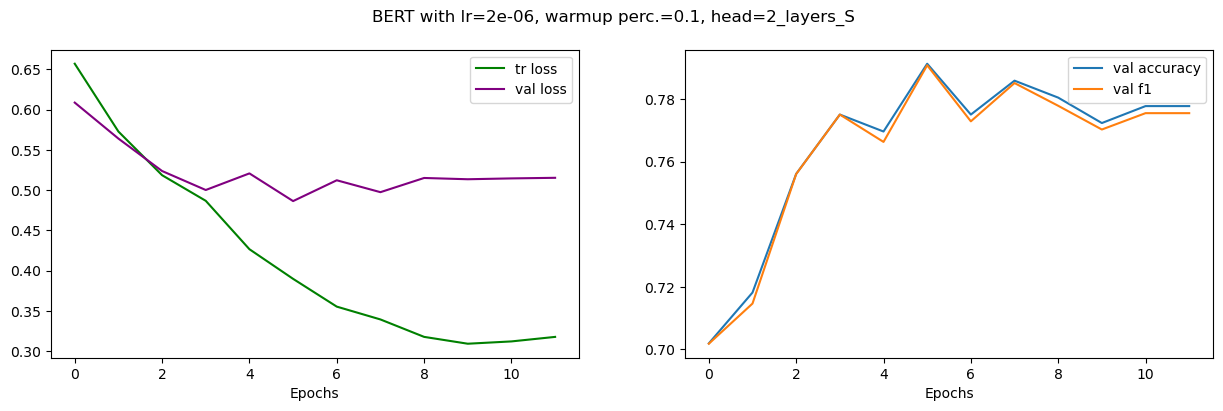

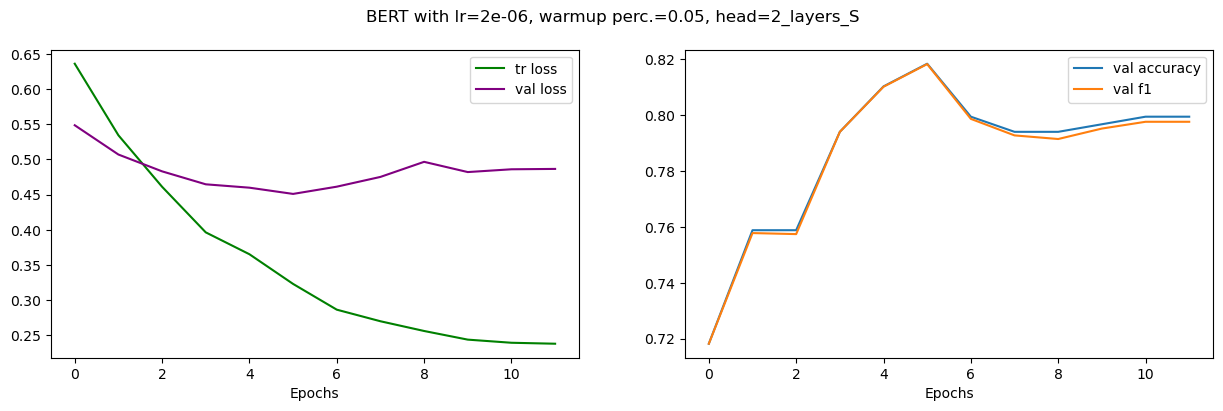

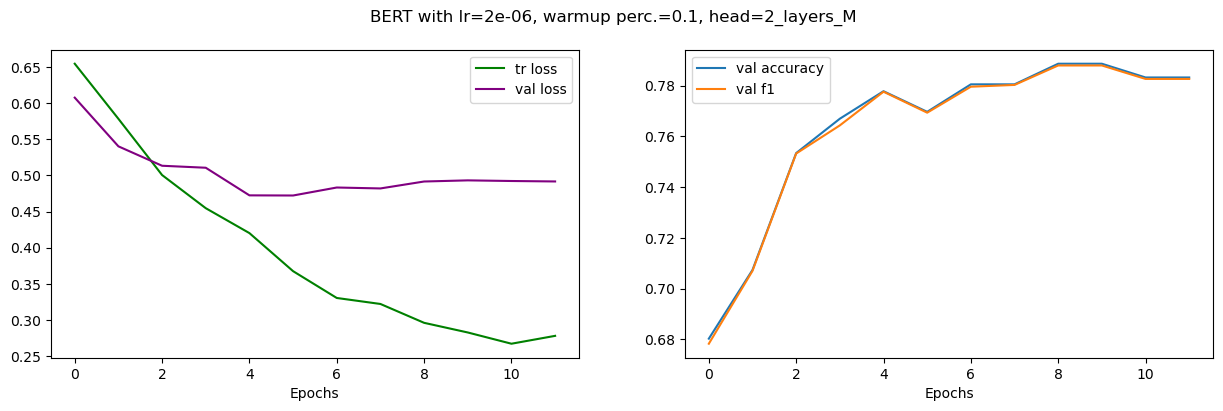

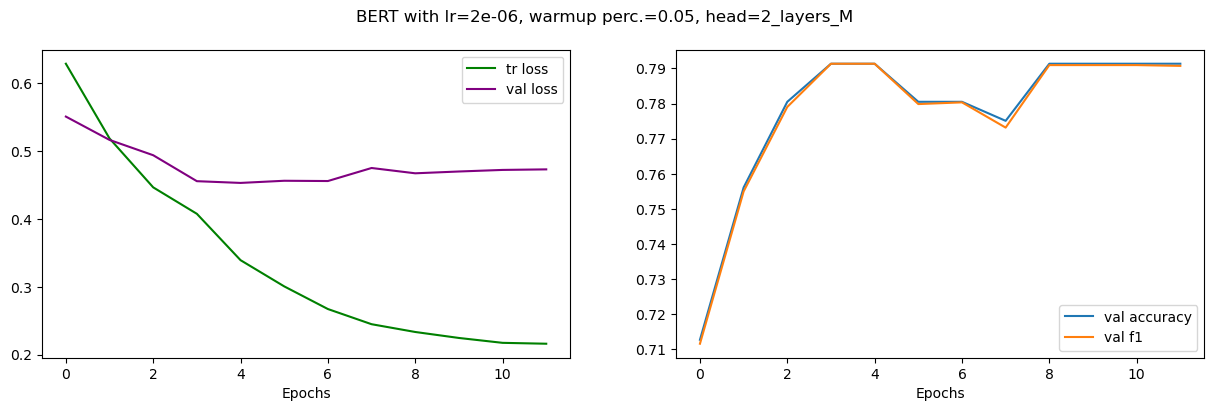

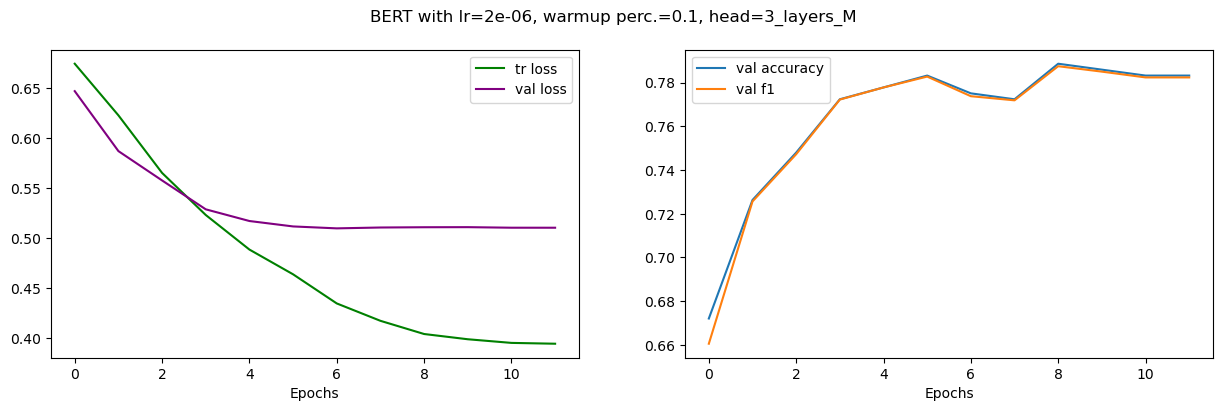

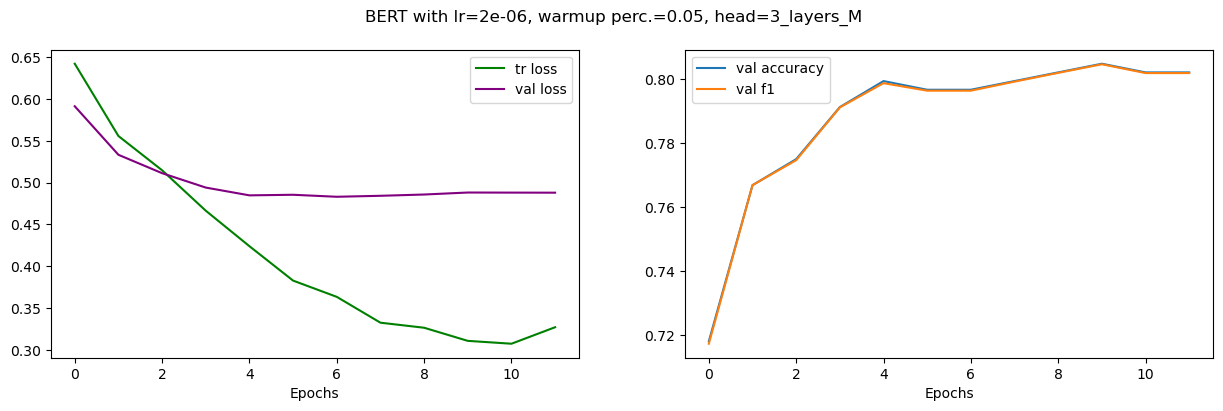

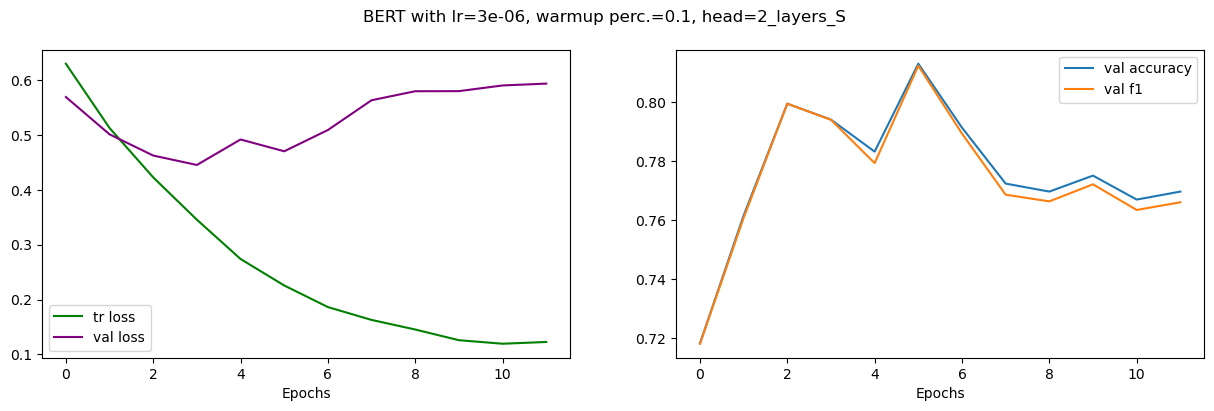

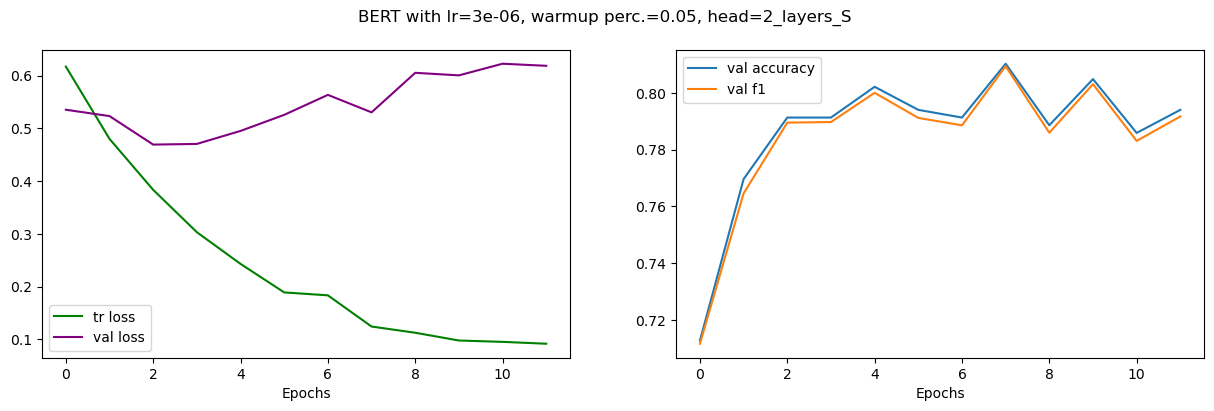

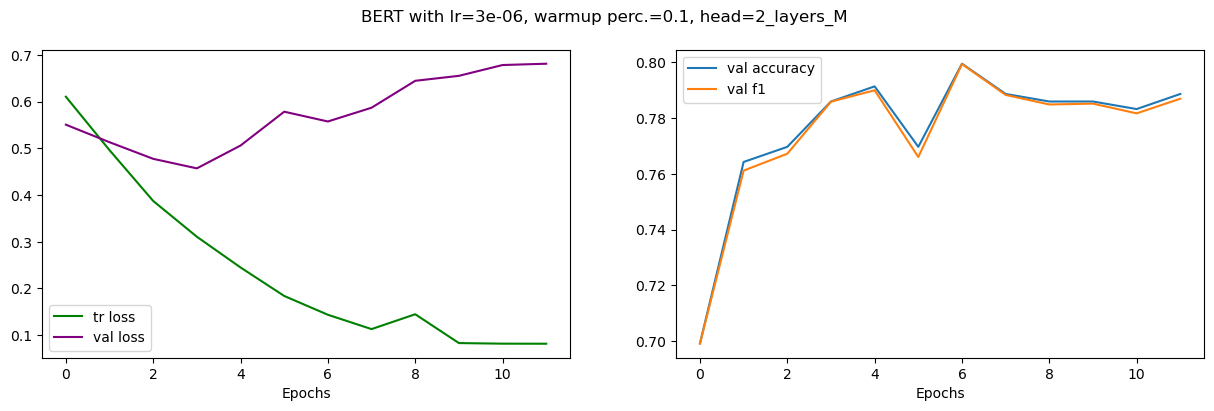

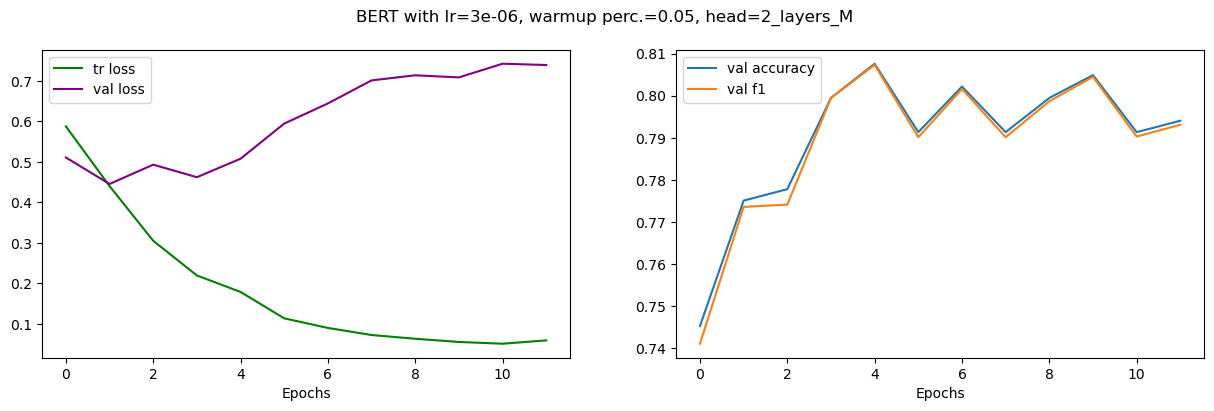

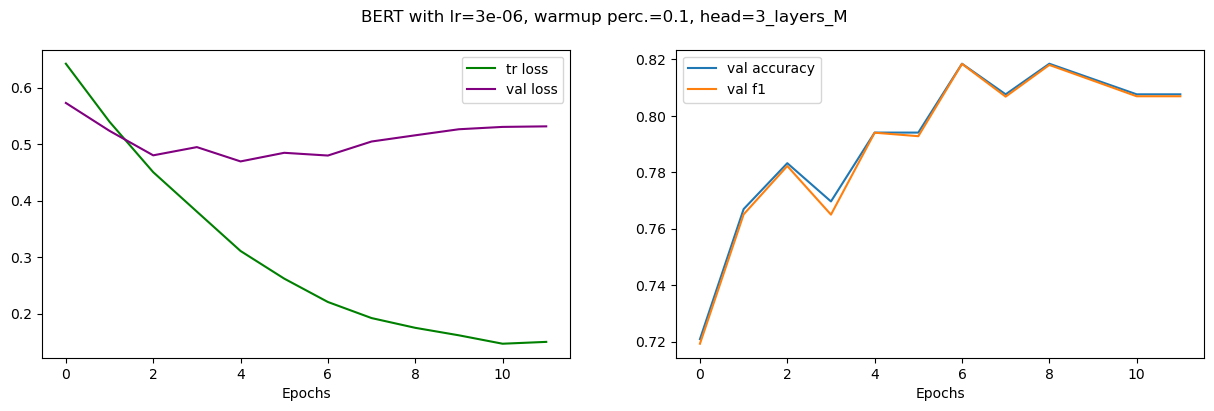

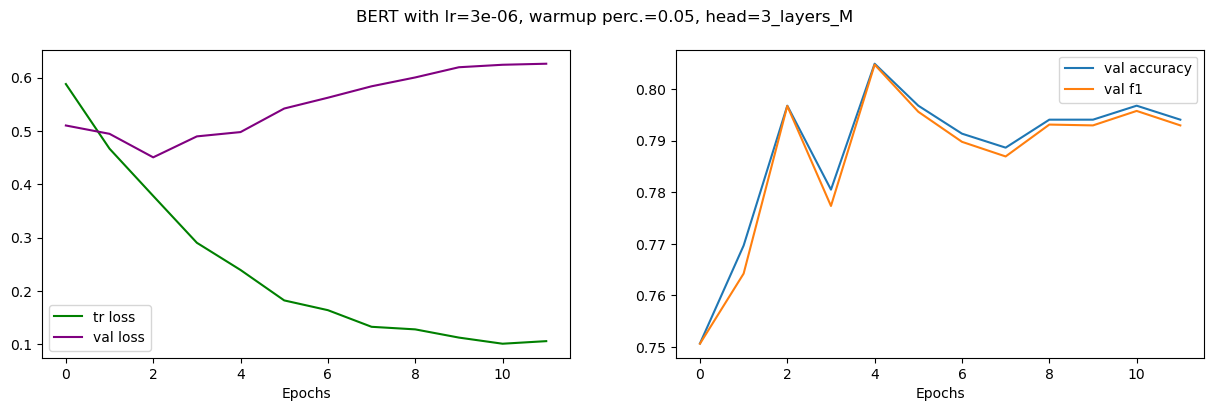

In [30]:
save_folder_pth = './bert_subtaskA/16_4_2023-5.1' # Grid search run to analyze TO CHANGE


best_f1_list = []

for lr in lr_list:
    for clf_head_tuple in clf_head_list:
        for warmup_perc in warmup_perc_list:
            
            # Model path subfolder
            model_folder_str = 'lr{}_warmup{}_head_{}'.format(lr, warmup_perc, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)

            title = 'BERT with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, clf_head_tuple[1])

            # Load model checkpoint for each epoch
            val_loss_list, tr_loss_list, val_f1_list, val_acc_list = [], [], [], []

            for epoch_i in range(max_epochs):
                model_pth = os.path.join(model_folder_pth,'bert_clf_{}.pt'.format(epoch_i))
                checkpoint = torch.load(model_pth)
                val_loss_list.append(checkpoint['val_loss'])
                tr_loss_list.append(checkpoint['tr_loss'])
                val_f1_list.append(checkpoint['val_f1'])
                val_acc_list.append(checkpoint['val_acc'])


            best_f1 = max(val_f1_list)
            best_epoch = val_f1_list.index(best_f1)
            best_f1_list.append((title, best_epoch, best_f1))


            plt.figure(figsize=(15,4))

            plt.subplot(1, 2, 1)
            plt.plot(tr_loss_list, label='tr loss', color='green')
            plt.plot(val_loss_list, label='val loss', color='purple')
            plt.xlabel('Epochs')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(val_acc_list, label='val accuracy')
            plt.plot(val_f1_list, label='val f1')
            plt.xlabel('Epochs')
            plt.legend()

            plt.suptitle(title)
            plt.show()



In [31]:
for title, epoch, f1 in best_f1_list:
    print('{} at epoch {}, F1: {:.4f}'.format(title, epoch, f1))

BERT with lr=1e-06, warmup perc.=0.1, head=2_layers_S at epoch 6, F1: 0.7451
BERT with lr=1e-06, warmup perc.=0.05, head=2_layers_S at epoch 7, F1: 0.7425
BERT with lr=1e-06, warmup perc.=0.1, head=2_layers_M at epoch 7, F1: 0.7317
BERT with lr=1e-06, warmup perc.=0.05, head=2_layers_M at epoch 9, F1: 0.7452
BERT with lr=1e-06, warmup perc.=0.1, head=3_layers_M at epoch 4, F1: 0.7263
BERT with lr=1e-06, warmup perc.=0.05, head=3_layers_M at epoch 5, F1: 0.7344
BERT with lr=2e-06, warmup perc.=0.1, head=2_layers_S at epoch 5, F1: 0.7908
BERT with lr=2e-06, warmup perc.=0.05, head=2_layers_S at epoch 5, F1: 0.8183
BERT with lr=2e-06, warmup perc.=0.1, head=2_layers_M at epoch 8, F1: 0.7879
BERT with lr=2e-06, warmup perc.=0.05, head=2_layers_M at epoch 4, F1: 0.7913
BERT with lr=2e-06, warmup perc.=0.1, head=3_layers_M at epoch 8, F1: 0.7875
BERT with lr=2e-06, warmup perc.=0.05, head=3_layers_M at epoch 9, F1: 0.8047
BERT with lr=3e-06, warmup perc.=0.1, head=2_layers_S at epoch 5, F1: 

## Choose and predict on test with best model

Best model is: BERT with lr=3e-06, warmup perc.=0.1, head=3_layers_M at epoch 6, F1: 0.8184 at Epoch 6

In [23]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [24]:
final_model_pth = 'bert_subtaskA/16_4_2023-5.1/lr3e-06_warmup0.1_head_3_layers_M/bert_clf_6.pt'

# Recover the best head configuration
head_3_layers_M = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 2),
                )
# Initialize and recover model checkpoint
final_model = BertClassifier(head=head_3_layers_M)
final_model.load_state_dict(torch.load(final_model_pth).get('model_state_dict'))

final_model.to(device)

# Prediction on test
test_preds = test_clf(final_model, test_dataloader, device)

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
print(test_preds)
# print occurrences of each class
print(np.unique(test_preds, return_counts=True))

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 

Generate result CSV

In [26]:
id_list = [i for i in range(len(test_preds))]
df = pd.DataFrame({'Id': id_list, 'Expected': test_preds})
df.to_csv('final_bert_submission.csv', index=False)